<h1>Import Libraries:</h1>

In [75]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.feature import Imputer
from pyspark.ml.feature import StringIndexer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score


In [8]:
spark = SparkSession.builder.appName("KNN_Churn").getOrCreate()

In [117]:
data = spark.read.csv("Master_data.csv", header=True,inferSchema=True)
data_test=spark.read.csv("data_test.csv",header=True,inferSchema=True)

In [16]:
data.head()

Row(State='KS', Account length='128', Area code='415', International plan='No', Voice mail plan='Yes', Number vmail messages='25', Total day minutes='265.1', Total day calls='110', Total day charge='45.07', Total eve minutes='197.4', Total eve calls='99', Total eve charge='16.78', Total night minutes='244.7', Total night calls='91', Total night charge='11.01', Total intl minutes='10.0', Total intl calls='3', Total intl charge='2.7', Customer service calls='1', Churn='False')

In [109]:
data_test.head(1)

[Row(_c0='State', _c1='Account length', _c2='Area code', _c3='International plan', _c4='Voice mail plan', _c5='Number vmail messages', _c6='Total day minutes', _c7='Total day calls', _c8='Total day charge', _c9='Total eve minutes', _c10='Total eve calls', _c11='Total eve charge', _c12='Total night minutes', _c13='Total night calls', _c14='Total night charge', _c15='Total intl minutes', _c16='Total intl calls', _c17='Total intl charge', _c18='Customer service calls', _c19='Churn')]

In [18]:
data.describe()

DataFrame[summary: string, State: string, Account length: string, Area code: string, International plan: string, Voice mail plan: string, Number vmail messages: string, Total day minutes: string, Total day calls: string, Total day charge: string, Total eve minutes: string, Total eve calls: string, Total eve charge: string, Total night minutes: string, Total night calls: string, Total night charge: string, Total intl minutes: string, Total intl calls: string, Total intl charge: string, Customer service calls: string, Churn: string]

In [31]:
selected_df.printSchema()

root
 |-- State: string (nullable = true)
 |-- Total day minutes: string (nullable = true)
 |-- Total eve minutes: string (nullable = true)
 |-- Total night minutes: string (nullable = true)
 |-- Total intl minutes: string (nullable = true)



In [43]:
data.columns

['State',
 'Account length',
 'Area code',
 'International plan',
 'Voice mail plan',
 'Number vmail messages',
 'Total day minutes',
 'Total day calls',
 'Total day charge',
 'Total eve minutes',
 'Total eve calls',
 'Total eve charge',
 'Total night minutes',
 'Total night calls',
 'Total night charge',
 'Total intl minutes',
 'Total intl calls',
 'Total intl charge',
 'Customer service calls',
 'Churn']

<h1>Visualisation</h1>

root
 |-- State: string (nullable = true)
 |-- Total day minutes: double (nullable = true)
 |-- Total eve minutes: double (nullable = true)
 |-- Total night minutes: double (nullable = true)
 |-- Total intl minutes: double (nullable = true)



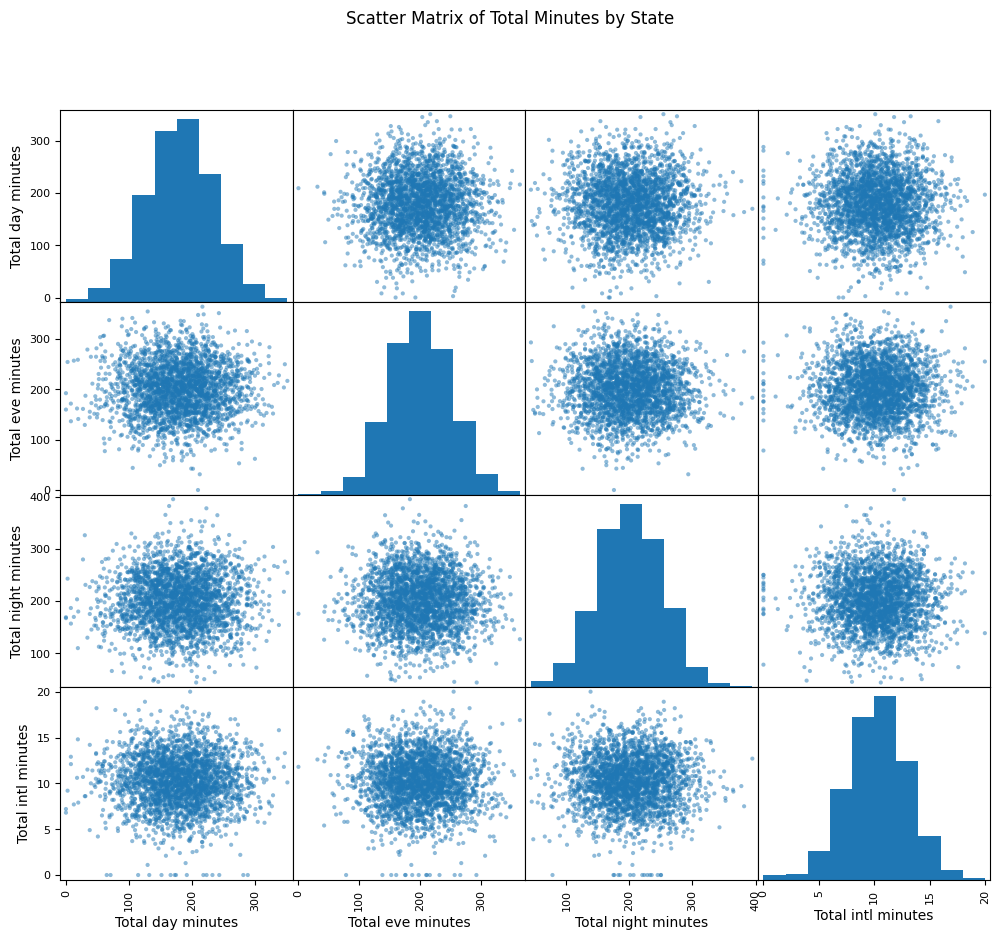

In [34]:

# Convertir les colonnes numériques de type string en type double
selected_df = data.select(
    col("State"),
    col("Total day minutes").cast("double"),
    col("Total eve minutes").cast("double"),
    col("Total night minutes").cast("double"),
    col("Total intl minutes").cast("double")
)

# Afficher le schéma mis à jour
selected_df.printSchema()

# Tracer un nuage de points pour chaque paire de colonnes
pd.plotting.scatter_matrix(selected_df.toPandas(), figsize=(12, 10))
plt.suptitle("Scatter Matrix of Total Minutes by State")
plt.show()

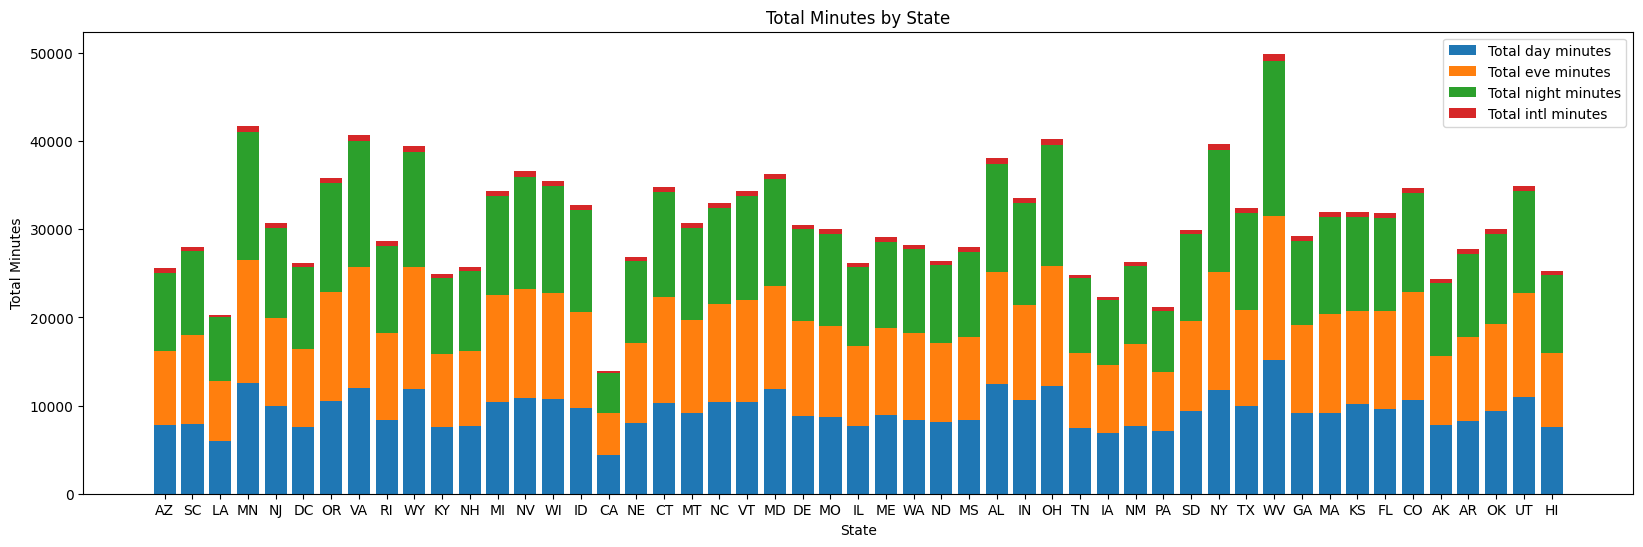

In [36]:
# Calculer le total des minutes par état
total_minutes_by_state = selected_df.groupBy("State").sum()
total_minutes_by_state = total_minutes_by_state.toPandas()

# Tracer un graphique à barres
plt.figure(figsize=(20, 6))
plt.bar(total_minutes_by_state["State"], total_minutes_by_state["sum(Total day minutes)"], label="Total day minutes")
plt.bar(total_minutes_by_state["State"], total_minutes_by_state["sum(Total eve minutes)"], bottom=total_minutes_by_state["sum(Total day minutes)"], label="Total eve minutes")
plt.bar(total_minutes_by_state["State"], total_minutes_by_state["sum(Total night minutes)"], bottom=total_minutes_by_state["sum(Total day minutes)"] + total_minutes_by_state["sum(Total eve minutes)"], label="Total night minutes")
plt.bar(total_minutes_by_state["State"], total_minutes_by_state["sum(Total intl minutes)"], bottom=total_minutes_by_state["sum(Total day minutes)"] + total_minutes_by_state["sum(Total eve minutes)"] + total_minutes_by_state["sum(Total night minutes)"], label="Total intl minutes")
plt.xlabel("State")
plt.ylabel("Total Minutes")
plt.title("Total Minutes by State")
plt.legend()
plt.show()

<h2>Traiter les données</h2>

In [52]:
# Vérifiez les valeurs nulles dans chaque colonne et comptez le nombre de valeurs nulles
missing_counts = [(col_name, data.where(col(col_name).isNull()).count()) for col_name in data.columns]

# Affichez le nombre de valeurs manquantes dans chaque colonne
for col_name, missing_count in missing_counts:
    print(col_name, missing_count)

State 0
Account length 0
Area code 0
International plan 0
Voice mail plan 0
Number vmail messages 0
Total day minutes 0
Total day calls 0
Total day charge 0
Total eve minutes 0
Total eve calls 0
Total eve charge 0
Total night minutes 0
Total night calls 0
Total night charge 0
Total intl minutes 0
Total intl calls 0
Total intl charge 0
Customer service calls 0
Churn 0


In [53]:
# Compter le nombre de lignes dupliquées
duplicate_counts = data.groupBy(data.columns).count().where(col("count") > 1)

# Afficher les lignes dupliquées
if duplicate_counts.count() == 0:
    print("Aucune ligne dupliquée n'a été trouvée.")
else:
    print("Lignes dupliquées :")
    duplicate_counts.show()

Aucune ligne dupliquée n'a été trouvée.


In [63]:
data=data.dropna

<h2>sélectionné les colonnes nécessaires</h2>

In [71]:


# Liste des colonnes à convertir de string en numérique
string_columns = ["State", "International plan", "Voice mail plan"]

# Convertir les colonnes de type string en numérique
indexers = [StringIndexer(inputCol=col, outputCol=col+"_index").fit(data) for col in string_columns]
data_indexed = data
for indexer in indexers:
    data_indexed = indexer.transform(data_indexed)

# Colonnes numériques et autres colonnes d'intérêt
numeric_columns = ["Account length", "Area code", "Number vmail messages", "Total day minutes", "Total day calls", "Total day charge", "Total eve minutes", "Total eve calls", "Total eve charge", "Total night minutes", "Total night calls", "Total night charge", "Total intl minutes", "Total intl calls", "Total intl charge", "Customer service calls"]
feature_columns = numeric_columns + [col + "_index" for col in string_columns]

# Assembler les caractéristiques
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
data_assembled = assembler.transform(data_indexed)

# Sélectionner les colonnes nécessaires
data_assembled = data_assembled.select("features", "Churn")


<h2>Entraînement</h2>

In [84]:
X_train = train_data.select("features").collect()
y_train = train_data.select("Churn").collect()

# Extraire les caractéristiques et les étiquettes sous forme de listes
X_train = [row.features.toArray() for row in X_train]
y_train = [row.Churn for row in y_train]


In [82]:

data_pd = data_assembled.select("features", "Churn").toPandas()

In [85]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [89]:
X_test = test_data.select("features").collect()

# Extraire les caractéristiques sous forme de listes de tableaux numpy
X_test = [row.features.toArray() for row in X_test]

# Prédire les étiquettes pour les données de test
y_pred = knn.predict(X_test)


<h2>prédiction</h2>

In [90]:
from sklearn.metrics import accuracy_score

# Convertir les étiquettes de test en listes
y_test = test_data.select("Churn").collect()
y_test = [row.Churn for row in y_test]

# Calculer le pourcentage de prédiction
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.8801597869507324


In [121]:
data_test.columns

['State',
 'Account length',
 'Area code',
 'International plan',
 'Voice mail plan',
 'Number vmail messages',
 'Total day minutes',
 'Total day calls',
 'Total day charge',
 'Total eve minutes',
 'Total eve calls',
 'Total eve charge',
 'Total night minutes',
 'Total night calls',
 'Total night charge',
 'Total intl minutes',
 'Total intl calls',
 'Total intl charge',
 'Customer service calls',
 'Churn']